# Video Time Series Data Extraction

In [1]:
import numpy as np
import csv
from collections import defaultdict
import os 
import cv2
from matplotlib import pyplot as plt


In [6]:


INPUT_PATH = "/home/snt/projects_lujun/benchmarking_nature_tsfm/data/video/LaSOT/swing/swing/swing-6/img"  # 可以是 "video.mp4" / 0 (摄像头) / "frames_folder"

MAX_CORNERS = 10
QUALITY_LEVEL = 0.01
MIN_DISTANCE = 12
BLOCK_SIZE = 3
USE_HARRIS = False  #  useHarrisDetector=True → 使用 Harris 角点检测  useHarrisDetector=False 使用 Shi-Tomasi 角点检测
K_HARRIS = 0.04  # If useHarrisDetector, don't set it

WIN_SIZE = (21, 21)
MAX_LEVEL = 3
TERM_CRITERIA = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 30, 0.01)

REDETECT_INTERVAL = 10  
FB_ERR_THRESH = 1.5      
ERR_THRESH = 30.0        

DRAW_TRAJ_LEN = 30      
OUTPUT_CSV = "tracks.csv" 



In [7]:
# ========== 统一的帧读取器 ==========
class FrameReader:
    def __init__(self, input_path):
        if isinstance(input_path, int) or input_path.endswith(".mp4") or input_path.endswith(".avi"):
            # 摄像头或视频
            self.mode = "video"
            self.cap = cv2.VideoCapture(input_path)
        elif os.path.isdir(input_path):
            # 图片文件夹
            self.mode = "images"
            files = sorted(os.listdir(input_path))
            self.files = [os.path.join(input_path, f) for f in files if f.lower().endswith((".png", ".jpg", ".jpeg"))]
            self.idx = 0
        else:
            raise ValueError("输入路径不合法: 既不是视频/摄像头，也不是图片文件夹")

    def read(self):
        if self.mode == "video":
            return self.cap.read()
        elif self.mode == "images":
            if self.idx >= len(self.files):
                return False, None
            frame = cv2.imread(self.files[self.idx])
            # print (self.idx)
            self.idx += 1
            return frame is not None, frame

    def release(self):
        if self.mode == "video":
            self.cap.release()
        

## 识别角点,输入是灰度图，输出是角点坐标
def detect_features(gray, mask=None, max_corners=MAX_CORNERS):
    pts = cv2.goodFeaturesToTrack(
        gray,
        maxCorners=max_corners,
        qualityLevel=QUALITY_LEVEL,
        minDistance=MIN_DISTANCE,
        blockSize=BLOCK_SIZE,
        useHarrisDetector=USE_HARRIS,
        k=K_HARRIS,
        mask=mask
    )
    if pts is None:
        return np.empty((0,1,2), dtype=np.float32)
    return np.float32(pts)

## 
def forward_backward_check(prev_gray, curr_gray, p0):
    # 正向
    p1, st1, err1 = cv2.calcOpticalFlowPyrLK(
        prev_gray, curr_gray, p0, None,
        winSize=WIN_SIZE, maxLevel=MAX_LEVEL, criteria=TERM_CRITERIA
    )
    # 反向
    p0_back, st2, err2 = cv2.calcOpticalFlowPyrLK(
        curr_gray, prev_gray, p1, None,
        winSize=WIN_SIZE, maxLevel=MAX_LEVEL, criteria=TERM_CRITERIA
    )
    # 前后向误差
    fb_err = np.linalg.norm(p0 - p0_back, axis=2).reshape(-1)
    err1_ = err1.reshape(-1) if err1 is not None else np.full(len(p0), np.inf)
    st = (st1.reshape(-1) == 1) & (st2.reshape(-1) == 1)
    return p1, st, fb_err, err1_

def in_bounds(p, w, h):
    x, y = p[:,0], p[:,1]
    return (x >= 0) & (x < w) & (y >= 0) & (y < h)





In [8]:
# ========== 主流程 ==========
# cap = cv2.VideoCapture(VIDEO_PATH)

reader = FrameReader(INPUT_PATH)
ok, frame0 = reader.read()
if not ok:
    raise RuntimeError("无法读取输入")

# 记录视频尺寸 h，w， 把首帧转为灰度
h, w = frame0.shape[:2]
prev_gray = cv2.cvtColor(frame0, cv2.COLOR_BGR2GRAY)


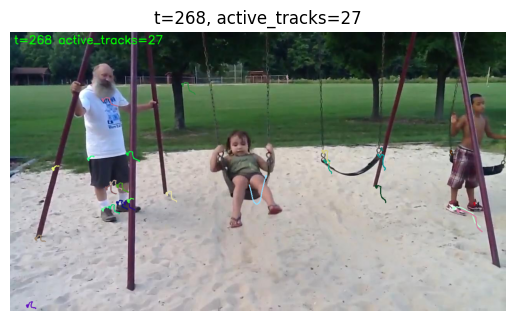

In [ ]:
import matplotlib.pyplot as plt
from IPython.display import display, clear_output


# 初始化角点与轨迹容器
p0 = detect_features(prev_gray, max_corners=MAX_CORNERS)
next_track_id = 0
# 为每个点分配一个track_id
active_ids = []
tracks = defaultdict(list)  # track_id -> [(t,x,y)]
colors = {}

def add_points(points, t):
    global next_track_id
    for pt in points.reshape(-1,2):
        tracks[next_track_id].append((t, float(pt[0]), float(pt[1])))
        active_ids.append(next_track_id)
        colors[next_track_id] = tuple(np.random.randint(0, 255, 3).tolist())
        next_track_id += 1

## 初始化第一帧所识别的所有角点
add_points(p0, t=0)
t = 0

# 用于可视化的轨迹缓存（只保留最近 DRAW_TRAJ_LEN 个）
vis_traj = defaultdict(list)  # track_id -> [(x,y), ...]

plt.ion()  # interactive mode
fig, ax = plt.subplots()

while True:
    ok, frame = reader.read()
    if not ok:
        break

    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    t += 1
    # print (t)
    # 若还有活跃轨迹：光流跟踪 + 质量筛选 + 更新
    if len(active_ids) > 0:
        # 组织上一帧的点坐标数组（与 active_ids 顺序一致）
        p0_arr = []
        for tid in active_ids:
            xlast, ylast = tracks[tid][-1][1], tracks[tid][-1][2]
            p0_arr.append([xlast, ylast])
        p0_arr = np.float32(p0_arr).reshape(-1,1,2)

        # LK + 前后向一致性
        p1, st, fb_err, err1_ = forward_backward_check(prev_gray, gray, p0_arr)  ## 正向估计新位置，反向验证， p1：本帧估计的新位置 st：前后向都成功的布尔标记 fb_err：前后向回投误差 err1_：正向 LK 误差

        # 质量筛选
        st = st & (fb_err < FB_ERR_THRESH) & (err1_ < ERR_THRESH)
        st = st & in_bounds(p1.reshape(-1,2), w, h)

        # 更新轨迹
        new_active_ids = []
        p1_flat = p1.reshape(-1,2)
        for keep, tid, new_pt in zip(st, active_ids, p1_flat):
            if keep:
                tracks[tid].append((t, float(new_pt[0]), float(new_pt[1])))
                new_active_ids.append(tid)
                # 更新可视化缓存
                vis_traj[tid].append((int(new_pt[0]), int(new_pt[1])))
                if len(vis_traj[tid]) > DRAW_TRAJ_LEN:
                    vis_traj[tid] = vis_traj[tid][-DRAW_TRAJ_LEN:]
        active_ids = new_active_ids

    # 周期性补点（避免与已有点太近）
    if t % REDETECT_INTERVAL == 0:
        mask = np.full((h, w), 255, dtype=np.uint8)
        for tid in active_ids:
            x, y = tracks[tid][-1][1], tracks[tid][-1][2]
            cv2.circle(mask, (int(x), int(y)), MIN_DISTANCE, 0, -1)
        new_pts = detect_features(gray, mask=mask, max_corners=MAX_CORNERS // 2)
        if new_pts is not None and len(new_pts) > 0:
            add_points(new_pts, t)

    vis = frame.copy()
    for tid in active_ids:
        c = colors[tid]
        pts_list = vis_traj[tid]
        for i in range(1, len(pts_list)):
            cv2.line(vis, pts_list[i-1], pts_list[i], c, 2)
        if len(pts_list) > 0:
            cv2.circle(vis, pts_list[-1], 3, c, -1)

    cv2.putText(vis, f"t={t} active_tracks={len(active_ids)}",
                (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1.0, (0,255,0), 2)

    # ---- 用 matplotlib 显示 ----
    # ax.clear()
    # ax.imshow(cv2.cvtColor(vis, cv2.COLOR_BGR2RGB))
    # ax.set_title(f"t={t}, active_tracks={len(active_ids)}")
    # ax.axis("off")
    # plt.pause(0.01)
    # print ("hello")
    # prev_gray = gray

    clear_output(wait=True)
    plt.imshow(cv2.cvtColor(vis, cv2.COLOR_BGR2RGB))
    plt.title(f"t={t}, active_tracks={len(active_ids)}")
    plt.axis("off")
    display(plt.gcf())            
    plt.pause(0.1)
    prev_gray = gray

plt.ioff()
plt.show()
